# Experimento: Clasificación de asuntos mediante Machine Learning supervisado (XGBoost)

## Descripción general

En esta notebook se implementa y evalúa un enfoque de clasificación automática
de asuntos administrativos utilizando modelos de Machine Learning supervisado,
con énfasis en el algoritmo XGBoost y la optimización de hiperparámetros mediante
GridSearchCV.

Este experimento representa el **baseline supervisado más avanzado** evaluado
en el proyecto, previo a la adopción de modelos de lenguaje.

---

## Objetivo del experimento

- Evaluar el desempeño de un modelo supervisado entrenado con datos históricos.
- Analizar el impacto del ajuste de hiperparámetros mediante GridSearchCV.
- Comparar los resultados con enfoques heurísticos, embeddings y LLM.
- Determinar si un modelo clásico puede ofrecer una solución productiva robusta.

---

## Enfoque metodológico

- Se utilizan representaciones vectoriales del texto (por ejemplo, TF-IDF u
  otras features derivadas del asunto).
- Se entrena un clasificador **XGBoost** utilizando etiquetas históricas.
- Se aplica **GridSearchCV** para la selección óptima de hiperparámetros.
- La evaluación se realiza sobre un conjunto de validación/test independiente,
  utilizando métricas estándar de clasificación.

---

## Resultados y observaciones

El enfoque basado en XGBoost presenta:

- Ventajas:
  - Buen desempeño en clases frecuentes.
  - Capacidad de modelar relaciones no lineales.
  - Métricas cuantitativas reproducibles.

- Limitaciones:
  - Dependencia fuerte de la distribución del dataset.
  - Dificultad para generalizar a redacciones no vistas.
  - Necesidad de retraining ante cambios en el dominio o en las áreas.

---

## Rol dentro del proyecto

Este experimento permitió establecer un **límite superior razonable** del
desempeño alcanzable con Machine Learning clásico supervisado.

Los resultados obtenidos, junto con el análisis de errores, motivaron la
elección de un enfoque basado en modelos de lenguaje, que mostró mayor
capacidad de generalización y menor dependencia del retraining continuo.


# ML_XGB_GridSearchCV
 * XGBoost
 * GridSearch
-------------------------------------
MESA DE ENTRADA-

Basada en: Análisis de sentimiento en el corpus TASS corpus aplicando machine learning tradicional

Basado en una [notebook original](https://colab.research.google.com/gist/sanchezcarlosjr/91c8b8588e339381ae2b75fa868ee7e8/clase1-clasificacion.ipynb#scrollTo=aI9ugCiwVfsZ) de Carlos Eduardo Sánchez Torres, para un curso a cargo de

* Dra. Helena M. Gomez Adorno, UNAM
* Miguel Angel Alvarez, CIMAT
* Victor Giovanni Morales, BUAP


# Herramientas

In [ ]:
! apt-get install tree
! pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (67.5 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def explore(df):
  count_vect = CountVectorizer()
  matrizBOW = count_vect.fit_transform(df)
  print("Shape ", matrizBOW.shape)
  print("Feature names", count_vect.get_feature_names_out())
  print("Vocabulary", count_vect.vocabulary_)

# Preparación de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
# 1) Cargar tus datos (id, asunto, cuerpo, area_destino)
df = pd.read_csv("/content/drive/MyDrive/Diplo-2025/Proyecto/24 11 Proyecto/Dataset_24-11.csv")  # ← arma este CSV

¿Qué es ``requests``?

Librería para realizar peticiones HTTP.

In [ ]:
df = df.rename(columns={
    "Asunto": "asunto",
    "AREA OBJETIVO": "area_objetivo"
})

df["area_objetivo"] = df["area_objetivo"].astype(str).str.strip()
df["asunto"] = df["asunto"].astype(str).str.strip()

In [ ]:
df.area_objetivo.value_counts()

,count
area_objetivo,
REGULARIZACION DOMINIAL,253
GESTION FINANCIERA,211
ESCRITURACIONES,150
MESA DE ENTRADAS,56
ADMINISTRACION,54
REGULARIZACION DOMINIAL/GESTION FINANCIERA,12
JURIDICO,8
REGULARIZACION DOMINIAL/ESCRITURACIONES,5
TECNICA,4


In [ ]:
df["asunto"] = df["asunto"].str.lower().str.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8')

In [ ]:
df['area_objetivo'] = df['area_objetivo'].str.strip()
print("Value counts after stripping whitespace:")
df['area_objetivo'].value_counts()

Value counts after stripping whitespace:


,count
area_objetivo,
REGULARIZACION DOMINIAL,253
GESTION FINANCIERA,211
ESCRITURACIONES,150
MESA DE ENTRADAS,56
ADMINISTRACION,54
REGULARIZACION DOMINIAL/GESTION FINANCIERA,12
JURIDICO,8
REGULARIZACION DOMINIAL/ESCRITURACIONES,5
TECNICA,4


In [ ]:
df['area_objetivo'] = df['area_objetivo'].replace(['REGULARIZACION DOMINIAL/GESTION FINANCIERA', 'REGULARIZACION DOMINIAL/ESCRITURACIONES'], 'REGULARIZACION DOMINIAL')
df['area_objetivo'] = df['area_objetivo'].replace('GESTION FINANCIERA/ESCRITURACIONES', 'GESTION FINANCIERA')


df['area_objetivo'].value_counts()

,count
area_objetivo,
REGULARIZACION DOMINIAL,270
GESTION FINANCIERA,214
ESCRITURACIONES,150
MESA DE ENTRADAS,56
ADMINISTRACION,54
JURIDICO,8
TECNICA,4


In [ ]:
df['area_objetivo_codificada'], _ = pd.factorize(df['area_objetivo'])

In [ ]:
area_mapping = dict(zip(df['area_objetivo'], df['area_objetivo_codificada']))
print("Mapping of 'AREA OBJETIVO' to Numerical Codes:")
print(area_mapping)

Mapping of 'AREA OBJETIVO' to Numerical Codes:
{'MESA DE ENTRADAS': 0, 'REGULARIZACION DOMINIAL': 1, 'GESTION FINANCIERA': 2, 'ADMINISTRACION': 3, 'ESCRITURACIONES': 4, 'JURIDICO': 5, 'TECNICA': 6}


In [ ]:
df.head()

,Fecha de creación,asunto,area_objetivo,area_objetivo_codificada
0,8/9/2025,adjuntar documentacion solicitada,MESA DE ENTRADAS,0
1,8/9/2025,cambio de titularidad para adjudicatarios,REGULARIZACION DOMINIAL,1
2,8/9/2025,cancelacion de hipoteca,GESTION FINANCIERA,2
3,8/9/2025,combustible para vehiculos oficiales - petrole...,ADMINISTRACION,3
4,8/9/2025,cupon de pago - cambio de titularidad,REGULARIZACION DOMINIAL,1


<Axes: xlabel='area_objetivo_codificada'>

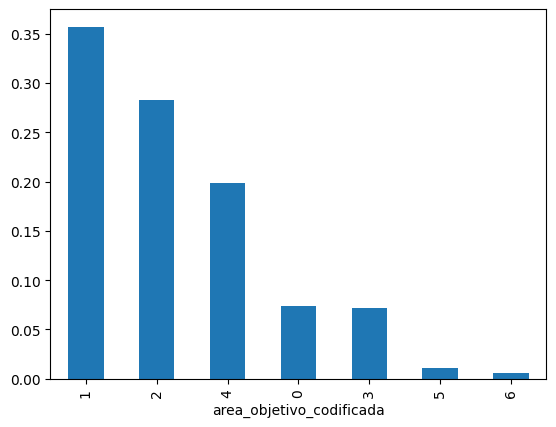

In [ ]:
df['area_objetivo_codificada'].value_counts(normalize=True).plot(kind="bar")

In [ ]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Exploración de datos

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

def mostFrequent(corpus):
    text = ' '.join(corpus)
    tokens= nltk.word_tokenize(text)
    cnt = Counter(tokens).most_common(20)
    return cnt


def explore(corpus):
  print("Most frequent ", mostFrequent(corpus))
  count_vect = CountVectorizer()
  matrizBOW = count_vect.fit_transform(corpus)
  print("DF Shape ", matrizBOW.shape)
  print("DF Feature names ", count_vect.get_feature_names_out())
  tfidf_vect = TfidfVectorizer()
  matriz_tfidf=tfidf_vect.fit_transform(corpus)
  print("TF IDF Shape ", matriz_tfidf.shape)
  print("DF Vocabulary ", tfidf_vect.vocabulary_)

# Preprocesamiento

In [ ]:
df.head()

,Fecha de creación,asunto,area_objetivo,area_objetivo_codificada
0,8/9/2025,adjuntar documentacion solicitada,MESA DE ENTRADAS,0
1,8/9/2025,cambio de titularidad para adjudicatarios,REGULARIZACION DOMINIAL,1
2,8/9/2025,cancelacion de hipoteca,GESTION FINANCIERA,2
3,8/9/2025,combustible para vehiculos oficiales - petrole...,ADMINISTRACION,3
4,8/9/2025,cupon de pago - cambio de titularidad,REGULARIZACION DOMINIAL,1


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
stop_words = set(stopwords.words('spanish'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words] # la, le, lo, me, ...
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# X_train = X_train.apply(preprocess_text)
# X_test = X_test.apply(preprocess_text)
df['asunto'] = df['asunto'].apply(preprocess_text)

In [ ]:
df['asunto']

,asunto
0,adjuntar documentacion solicitada
1,cambio titularidad adjudicatarios
2,cancelacion hipoteca
3,combustible vehiculos oficiales - petrolera sa...
4,cupon pago - cambio titularidad
...,...
751,turno escritura
752,escritura terreno segundo testimonio
753,ponerme dia deuda
754,direccion vivienda - solicita inscripcion domi...


Claro, la línea de código X_train['processed_text'] = X_train.apply(preprocess_text) realiza lo siguiente:

X_train: Es un DataFrame o Series de pandas que contiene los datos de entrenamiento, específicamente el texto original de los 'asuntos'.
['processed_text']: Indica que se está creando una nueva columna en X_train llamada processed_text.
.apply(preprocess_text): Este es un método de pandas que aplica la función preprocess_text a cada elemento (cada texto de 'asunto') de X_train.
preprocess_text: Es una función personalizada (definida en celdas anteriores) que toma un texto como entrada y realiza los siguientes pasos de preprocesamiento:
Convierte el texto a minúsculas.
Elimina cualquier mención de usuario (patrones que comienzan con '@').
Tokeniza el texto (lo divide en palabras).
Filtra las palabras, eliminando las "stop words" en español (palabras comunes como 'la', 'el', 'un', etc.).
Une las palabras filtradas de nuevo en una sola cadena de texto.
En resumen, esta línea de código procesa cada 'asunto' en tu conjunto de datos de entrenamiento (X_train) utilizando la función preprocess_text y guarda el texto limpio y preprocesado en una nueva columna llamada processed_text dentro de X_train.

## Duplicados

In [ ]:
print(f"Number of duplicate rows in df: {df.duplicated(subset=['asunto']).sum()}")

Number of duplicate rows in df: 216


In [ ]:
print(f"Number of duplicate rows in df_filtered: {df.duplicated(subset=['asunto']).sum()}")
if df.duplicated().sum() > 0:
    print("Duplicate rows:")
    print(df[df.duplicated(subset=['asunto'],keep=False)].sort_values(by='asunto'))
else:
    print("No duplicate rows found.")

Number of duplicate rows in df_filtered: 216
Duplicate rows:
    Fecha de creación                                             asunto  \
732        29/07/2025                         actualizar cedulon vencido   
456        10/07/2025                         actualizar cedulon vencido   
719        28/07/2025  adelantamiento cuotas planes provinciales vivi...   
407        06/07/2025  adelantamiento cuotas planes provinciales vivi...   
118         12/9/2025  adelantamiento cuotas planes provinciales vivi...   
..                ...                                                ...   
243         19/9/2025  suministro gas natural - distribuidora gas cen...   
481        11/07/2025  suministro gas natural - distribuidora gas cen...   
620        21/07/2025                                           vivienda   
244         19/9/2025                                           vivienda   
68           9/9/2025                                           vivienda   

          area_objetivo  a

In [ ]:
df.shape

(756, 4)

In [ ]:
df = df.drop_duplicates(subset=['asunto'])
df.shape

(540, 4)

In [ ]:
df.columns

Index(['Fecha de creación', 'asunto', 'area_objetivo',
       'area_objetivo_codificada'],
      dtype='object')

# Vectorizamos

In [ ]:
def generate_vectorizer():
  vectorizer = TfidfVectorizer(ngram_range=(1,2), analyzer='char_wb')
  def vectorize(corpus, is_train=True):
    if is_train:
        return vectorizer.fit_transform(corpus)
    else:
        return vectorizer.transform(corpus)
  return vectorize, vectorizer

# Separamos en Train y Test


In [ ]:
from sklearn.model_selection import train_test_split
vectorize, vectorizer = generate_vectorizer()

X_train, X_test, y_train, y_test = train_test_split(df['asunto'],df['area_objetivo_codificada'], test_size=0.2, random_state=42, stratify=df['area_objetivo_codificada'])
X_train_vect = vectorize(X_train, is_train=True)
X_test_vect = vectorize(X_test, is_train=False)

In [ ]:
X_train_vect

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 20529 stored elements and shape (432, 551)>

In [ ]:
X_test_vect

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5271 stored elements and shape (108, 551)>

In [ ]:
y_train

,area_objetivo_codificada
369,1
476,1
559,1
68,0
736,4
...,...
104,1
361,4
11,3
468,2


In [ ]:
y_test

,area_objetivo_codificada
703,1
685,1
127,1
500,4
628,1
...,...
603,3
211,6
597,1
138,1


# Entrenamiento

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


param_grid_xgb = {
    'n_estimators': [50,200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, verbose=3)

In [ ]:
grid_search_xgb

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                         'learning_rate': [0.01, 0.1, 0.3], 'max_depth': [3, 7],
                         'n_estimators': [50, 200]},
             verbose=3)

# XGBoost -- Grid_Search

In [ ]:
grid_search_xgb.fit(X_train_vect,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:40:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.736 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:40:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.770 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.721 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.860 total time=   4.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.779 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.828 total time=   5.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.839 total time=   8.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.837 total time=   5.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.860 total time=   8.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.860 total time=   7.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.724 total time=  10.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.770 total time=  11.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:42:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.756 total time=  12.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:42:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.849 total time=  10.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:42:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.802 total time=   9.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:42:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.793 total time=  22.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:43:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.851 total time=  14.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:43:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.826 total time=  14.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:43:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.872 total time=  14.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:43:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.849 total time=  15.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.828 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.851 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.872 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.849 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.849 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.851 total time=   3.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.862 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.895 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.860 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.872 total time=   5.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.862 total time=   2.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.885 total time=   2.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.860 total time=   2.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.872 total time=   2.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.884 total time=   4.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.839 total time=   3.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.885 total time=   3.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.884 total time=   4.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.860 total time=   5.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.895 total time=   3.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.839 total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.862 total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.895 total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.860 total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.860 total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.816 total time=   4.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.885 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.884 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.872 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.884 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.851 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.862 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.884 total time=   1.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.860 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.884 total time=   4.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.839 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.862 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.884 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.849 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.884 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.736 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.770 total time=   1.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.721 total time=   3.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.860 total time=   3.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.779 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.828 total time=   7.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.851 total time=   6.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.837 total time=   8.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:46:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.860 total time=   5.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:46:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.860 total time=   8.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:46:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.724 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:46:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.782 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:46:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.756 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:46:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.849 total time=   5.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:46:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.802 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:46:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.805 total time=  14.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:46:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.851 total time=  13.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:47:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.814 total time=  13.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:47:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.872 total time=  13.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:47:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.860 total time=  14.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:47:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.828 total time=   1.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:47:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.851 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:47:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.884 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:47:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.849 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:47:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.849 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:47:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.851 total time=   5.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:47:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.874 total time=   2.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:47:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.895 total time=   2.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:47:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.872 total time=   2.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.872 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.862 total time=   4.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.885 total time=   2.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.884 total time=   2.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.860 total time=   2.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.884 total time=   2.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.862 total time=   5.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.885 total time=   3.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.872 total time=   3.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.849 total time=   3.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.872 total time=   5.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.1, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.874 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.1, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.885 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.1, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.907 total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.1, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.860 total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.1, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.860 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.1, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.874 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.1, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.874 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.1, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.907 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.1, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.860 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.1, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.860 total time=   4.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.1, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.862 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.1, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.862 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.1, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.895 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.1, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.837 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.1, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.884 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.1, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.862 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.1, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.862 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.1, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.895 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:48:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.1, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.837 total time=   3.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:49:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.1, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.884 total time=   1.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:49:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.736 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:49:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.770 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:49:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.721 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:49:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.860 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:49:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.779 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:49:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.828 total time=   8.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:49:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.839 total time=   5.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:49:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.837 total time=   8.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:49:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.860 total time=   5.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:49:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.860 total time=   8.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:49:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.724 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:49:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.770 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:49:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.767 total time=   5.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:50:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.860 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:50:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.802 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:50:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.793 total time=  13.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:50:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.851 total time=  13.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:50:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.826 total time=  13.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:50:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.872 total time=  13.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.872 total time=  13.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.828 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.874 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.884 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.837 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.860 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.839 total time=   2.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.874 total time=   2.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.895 total time=   2.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.884 total time=   2.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.860 total time=   4.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.862 total time=   2.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.874 total time=   2.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.895 total time=   2.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.849 total time=   2.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.860 total time=   4.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.862 total time=   3.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.885 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.884 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:51:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.837 total time=   5.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.2, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.860 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.2, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.839 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.2, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.862 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.2, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.884 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.2, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.872 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.2, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.860 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.2, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.839 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.2, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.862 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.2, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.884 total time=   3.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.2, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.872 total time=   1.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.2, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.860 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.2, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.851 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.2, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.862 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.2, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.884 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.2, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.837 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.2, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.872 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.2, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.851 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.2, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.862 total time=   1.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.2, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.884 total time=   4.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.2, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.837 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.2, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.872 total time=   1.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.736 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.770 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.721 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.860 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.779 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.828 total time=   7.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.851 total time=   8.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.837 total time=   6.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:53:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.849 total time=   8.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:53:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.860 total time=   6.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:53:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.736 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:53:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.770 total time=   5.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:53:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.767 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:53:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.860 total time=   4.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:53:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.814 total time=   5.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:53:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.793 total time=  12.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.851 total time=  13.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.826 total time=  13.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:54:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.872 total time=  13.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:54:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.872 total time=  13.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:54:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.828 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:54:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.874 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:54:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.872 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:54:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.849 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:54:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.849 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:54:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.851 total time=   2.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:54:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.885 total time=   2.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.884 total time=   2.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.860 total time=   4.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.837 total time=   2.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.851 total time=   1.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.862 total time=   2.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.872 total time=   1.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.837 total time=   3.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.884 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.851 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.862 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.872 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.849 total time=   5.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.860 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.828 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.874 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.884 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.872 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.837 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.828 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.874 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.884 total time=   3.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.872 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.837 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.3, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.851 total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.3, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.874 total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.3, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.872 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.3, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.837 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.3, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.837 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.3, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.851 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:55:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.3, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.874 total time=   4.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.3, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.872 total time=   1.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.3, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.837 total time=   1.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.3, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.837 total time=   1.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.736 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.770 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.721 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.860 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.779 total time=   3.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.828 total time=   5.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.851 total time=   8.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.837 total time=   5.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.849 total time=   8.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.860 total time=   5.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.4, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.736 total time=   3.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:56:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.4, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.759 total time=   5.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:57:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.4, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.767 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:57:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.4, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.860 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:57:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.4, learning_rate=0.01, max_depth=7, n_estimators=50;, score=0.814 total time=   3.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:57:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.4, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.816 total time=  12.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:57:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.4, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.851 total time=  13.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:57:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.4, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.826 total time=  13.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:57:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.4, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.872 total time=  13.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.4, learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.860 total time=  13.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.828 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.851 total time=   1.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.860 total time=   3.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.837 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.849 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.839 total time=   2.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.851 total time=   2.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.884 total time=   2.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.849 total time=   4.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.837 total time=   2.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.862 total time=   1.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.851 total time=   1.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.895 total time=   1.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.837 total time=   2.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.872 total time=   4.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.862 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.874 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.872 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:58:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.826 total time=   5.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.4, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.872 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.4, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.839 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.4, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.862 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.4, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.895 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.4, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.837 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.4, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.837 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.4, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.839 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.4, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.862 total time=   1.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.4, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.895 total time=   3.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.4, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.837 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.4, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.837 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.4, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.874 total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.4, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.862 total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.4, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.860 total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.4, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.849 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.4, learning_rate=0.3, max_depth=7, n_estimators=50;, score=0.849 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END gamma=0.4, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.874 total time=   1.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END gamma=0.4, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.862 total time=   4.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END gamma=0.4, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.860 total time=   1.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END gamma=0.4, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.849 total time=   1.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END gamma=0.4, learning_rate=0.3, max_depth=7, n_estimators=200;, score=0.849 total time=   1.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:59:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                         'learning_rate': [0.01, 0.1, 0.3], 'max_depth': [3, 7],
                         'n_estimators': [50, 200]},
             verbose=3)

In [ ]:
print("Best parameters for XGB: ", grid_search_xgb.best_params_)
print("Best score for XGB: ", grid_search_xgb.best_score_)

Best parameters for XGB:  {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50}
Best score for XGB:  0.8773055332798716


In [ ]:
clf = XGBClassifier(gamma=0.1,
                    learning_rate=0.3,
                    max_depth=3,
                    n_estimators=50,
                    eval_metric='logloss')
clf.fit(X_train_vect, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
accuracy_score(y_test, clf.predict(X_test_vect)), \
precision_score(y_test, clf.predict(X_test_vect),average='macro'), \
recall_score(y_test, clf.predict(X_test_vect),average='macro'), \
f1_score(y_test, clf.predict(X_test_vect),average='macro')

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.8796296296296297, 0.6270502645502646, 0.625170068027211, 0.6235097547791046)

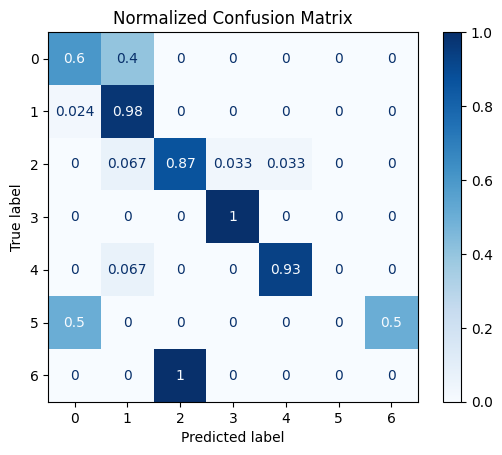

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test_vect)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.show()

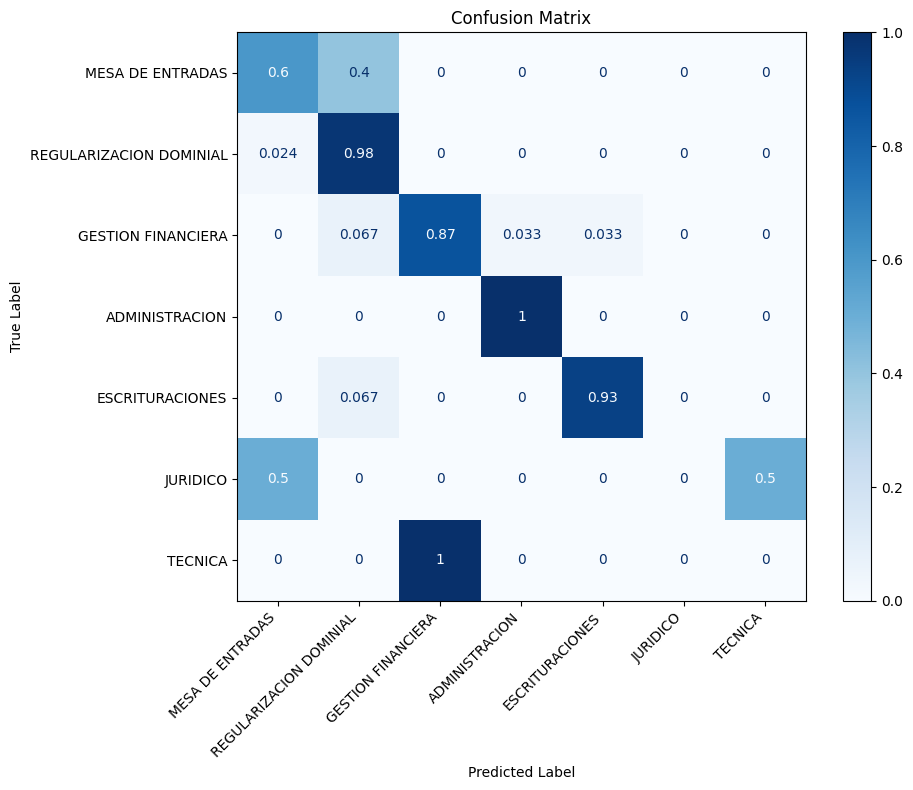

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix

cm = confusion_matrix(y_test, y_pred, normalize='true')

# Get the class labels from the area_mapping dictionary
# First, reverse the area_mapping to map numerical codes back to original area names
reverse_area_mapping = {v: k for k, v in area_mapping.items()}
# Sort the labels by their numerical code to match the order in the confusion matrix
class_labels = [reverse_area_mapping[i] for i in sorted(reverse_area_mapping.keys())]

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right') # Rotate labels for better visibility
plt.tight_layout()
plt.show()

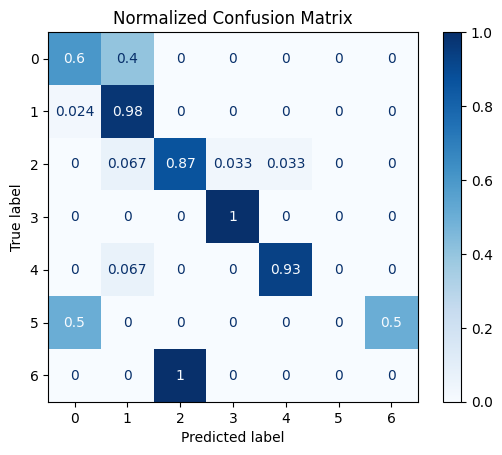

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test_vect)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
area_mapping

{'MESA DE ENTRADAS': 0,
 'REGULARIZACION DOMINIAL': 1,
 'GESTION FINANCIERA': 2,
 'ADMINISTRACION': 3,
 'ESCRITURACIONES': 4,
 'JURIDICO': 5,
 'TECNICA': 6}

#Visualizamos los resultados

In [ ]:
test = pd.DataFrame({
    'X_test': X_test,
    'y_test': y_test,
    'Predict': y_pred
})

In [ ]:
area_mapping

{'MESA DE ENTRADAS': 0,
 'REGULARIZACION DOMINIAL': 1,
 'GESTION FINANCIERA': 2,
 'ADMINISTRACION': 3,
 'ESCRITURACIONES': 4,
 'JURIDICO': 5,
 'TECNICA': 6}

In [ ]:
reverse_area_mapping

{0: 'MESA DE ENTRADAS',
 1: 'REGULARIZACION DOMINIAL',
 2: 'GESTION FINANCIERA',
 3: 'ADMINISTRACION',
 4: 'ESCRITURACIONES',
 5: 'JURIDICO',
 6: 'TECNICA'}

In [ ]:
test['area_objetivo_nombre'] = test['y_test'].map(reverse_area_mapping)
test['area_pred_top1'] = test['Predict'].map(reverse_area_mapping)

In [ ]:
test

,X_test,y_test,Predict,area_objetivo_nombre,area_pred_top1
703,cambio titularidad boleto compraventa,1,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL
685,documentacion solicitada cambio titularidad,1,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL
127,solicitar cambio titularidad,1,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL
500,necesito escriturar lote poder venderlo- augus...,4,4,ESCRITURACIONES,ESCRITURACIONES
628,refinanciacion deuda,1,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL
...,...,...,...,...,...
603,factura 1580 sellos quer,3,3,ADMINISTRACION,ADMINISTRACION
211,copias planos impresiones - cibanik celeste ya...,6,2,TECNICA,GESTION FINANCIERA
597,ref . direccion vivienda . cambio titularidad ...,1,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL
138,solicito regularizacion deuda .,1,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL


 MÉTRICAS GENERALES DEL MODELO ML - LogisticRegression - GriSearchCV

Accuracy top-1: 0.8796296296296297

Reporte de clasificación:

                         precision    recall  f1-score   support

         ADMINISTRACION       0.89      1.00      0.94         8
        ESCRITURACIONES       0.93      0.93      0.93        15
     GESTION FINANCIERA       0.96      0.87      0.91        30
               JURIDICO       0.00      0.00      0.00         2
       MESA DE ENTRADAS       0.75      0.60      0.67        10
REGULARIZACION DOMINIAL       0.85      0.98      0.91        42
                TECNICA       0.00      0.00      0.00         1

               accuracy                           0.88       108
              macro avg       0.63      0.63      0.62       108
           weighted avg       0.86      0.88      0.87       108


 MATRIZ DE CONFUSIÓN



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


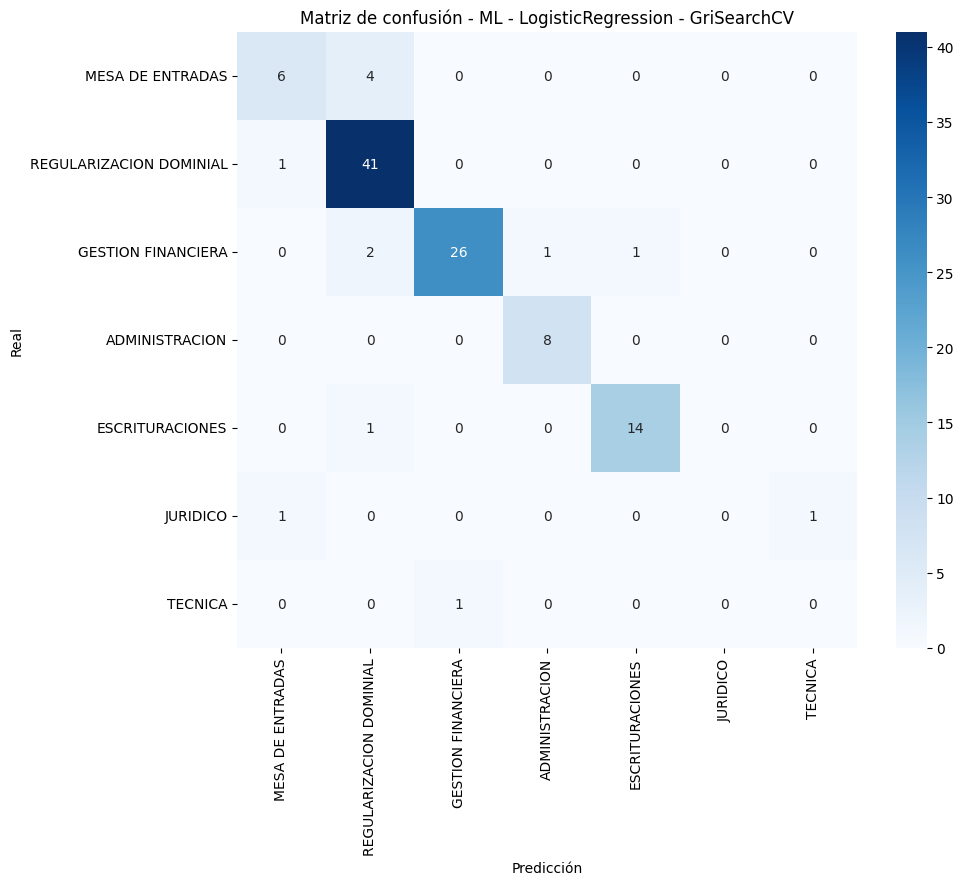

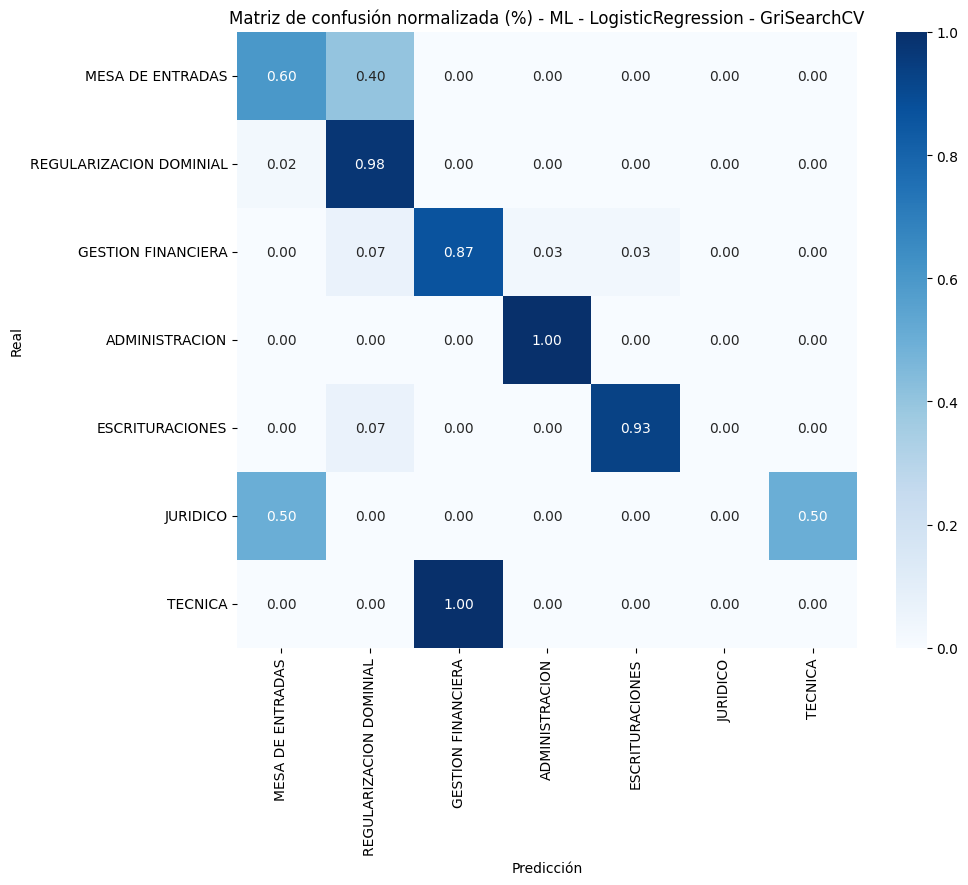


 TOP ERRORES (primeros 15)



,X_test,area_objetivo_nombre,area_pred_top1
412,recurso reconsideracion - juan vazquez,JURIDICO,TECNICA
627,necesito adjunto hoja rota necesaria,MESA DE ENTRADAS,REGULARIZACION DOMINIAL
744,solicito copia libre deuda n 8574 gracia marta ines,GESTION FINANCIERA,ADMINISTRACION
658,ref . direccion vivienda `` solicitud baja plan viviendas lotengo `` .,MESA DE ENTRADAS,REGULARIZACION DOMINIAL
95,consulta tramite,MESA DE ENTRADAS,REGULARIZACION DOMINIAL
253,consulta cuotas vivienda adjudicada direccion general vivienda,GESTION FINANCIERA,REGULARIZACION DOMINIAL
25,solicitud escrituracion vivienda - beneficiario,ESCRITURACIONES,REGULARIZACION DOMINIAL
599,quiero terminar d pagar escriturar,GESTION FINANCIERA,ESCRITURACIONES
624,oficio judicial sentencia divorcio,JURIDICO,MESA DE ENTRADAS
183,vivienda desocupadas abandono,REGULARIZACION DOMINIAL,MESA DE ENTRADAS



 ACCURACY POR ÁREA



/tmp/ipython-input-2036379144.py:95: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (test["area_pred_top1"] == test["area_objetivo_nombre"]).mean())


,0
area_objetivo_nombre,
ADMINISTRACION,0.87963
ESCRITURACIONES,0.87963
GESTION FINANCIERA,0.87963
JURIDICO,0.87963
MESA DE ENTRADAS,0.87963
REGULARIZACION DOMINIAL,0.87963
TECNICA,0.87963


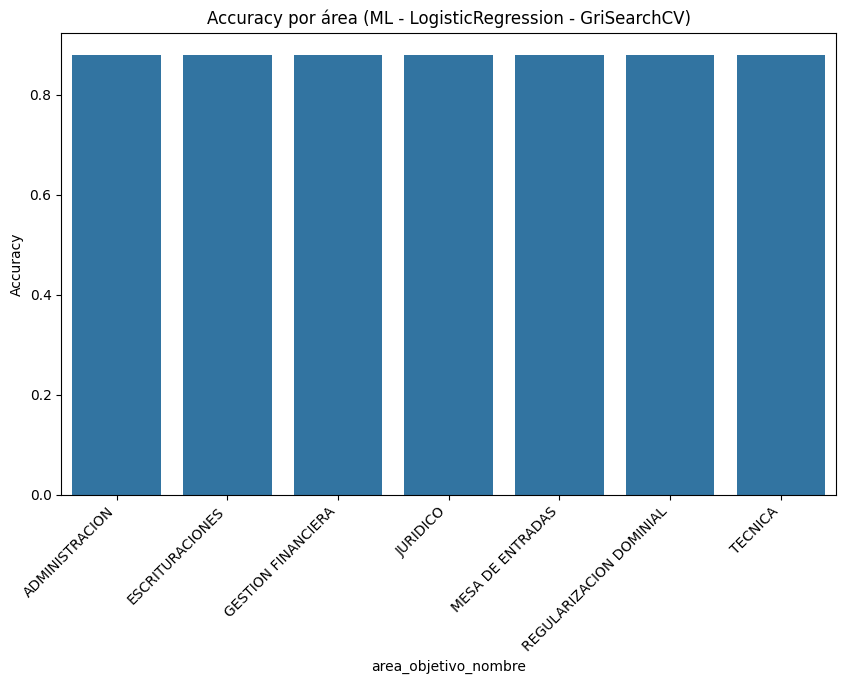


 MATRIZ DE CONFUSIÓN (crudo)



,MESA DE ENTRADAS,REGULARIZACION DOMINIAL,GESTION FINANCIERA,ADMINISTRACION,ESCRITURACIONES,JURIDICO,TECNICA
MESA DE ENTRADAS,6,4,0,0,0,0,0
REGULARIZACION DOMINIAL,1,41,0,0,0,0,0
GESTION FINANCIERA,0,2,26,1,1,0,0
ADMINISTRACION,0,0,0,8,0,0,0
ESCRITURACIONES,0,1,0,0,14,0,0
JURIDICO,1,0,0,0,0,0,1
TECNICA,0,0,1,0,0,0,0



 INTERPRETACIÓN BÁSICA:


• Filas = área real
• Columnas = predicción del modelo

• Si una fila tiene muchas predicciones en otra columna → confusión frecuente
  (ej: RD → Administración significa que muchos asuntos de RD
   se clasifican como Administración).

• Si la diagonal es alta → buen rendimiento general.


 PALABRAS FRECUENTES EN ERRORES

Top 50 palabras frecuentes en asuntos mal clasificados:

vivienda: 5
adjunto: 2
direccion: 2
solicitud: 2
consulta: 2
sentencia: 2
divorcio: 2
recurso: 1
reconsideracion: 1
juan: 1
vazquez: 1
necesito: 1
hoja: 1
rota: 1
necesaria: 1
solicito: 1
copia: 1
libre: 1
deuda: 1
n: 1
gracia: 1
marta: 1
ines: 1
ref: 1
baja: 1
plan: 1
viviendas: 1
lotengo: 1
tramite: 1
cuotas: 1
adjudicada: 1
general: 1
escrituracion: 1
beneficiario: 1
quiero: 1
terminar: 1
d: 1
pagar: 1
escriturar: 1
oficio: 1
judicial: 1
desocupadas: 1
abandono: 1
pago: 1
unico: 1
rapipago: 1
copias: 1
planos: 1
impresiones: 1
cibanik: 1


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# === CONFIGURACIÓN DEL EXPERIMENTO ===
MODEL_TAG = "ML - LogisticRegression - GriSearchCV"  # para los títulos

# === 1. CARGA DE DATOS ===

df = test.copy()

y_true = test['area_objetivo_nombre']
y_pred = test['area_pred_top1']

labels = class_labels


# === 2. MÉTRICAS GENERALES ===

print("====================================")
print(f" MÉTRICAS GENERALES DEL MODELO {MODEL_TAG}")
print("====================================\n")

print("Accuracy top-1:", accuracy_score(y_true, y_pred))
print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred))


# === 3. MATRIZ DE CONFUSIÓN ===

print("\n====================================")
print(" MATRIZ DE CONFUSIÓN")
print("====================================\n")

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.title(f"Matriz de confusión - {MODEL_TAG}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# === MATRIZ NORMALIZADA ===

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.title(f"Matriz de confusión normalizada (%) - {MODEL_TAG}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


# === 4. ERRORES MÁS IMPORTANTES ===

df_errores = test[test["area_objetivo_nombre"] != test["area_pred_top1"]]

print("\n====================================")
print(" TOP ERRORES (primeros 15)")
print("====================================\n")

pd.set_option('display.max_colwidth', None)
display(df_errores[["X_test", "area_objetivo_nombre", "area_pred_top1"]].head(15))


# === 5. ANALISIS DE ACCURACY POR ÁREA ===

print("\n====================================")
print(" ACCURACY POR ÁREA")
print("====================================\n")

accuracy_por_area = (
    df.groupby("area_objetivo_nombre")
    .apply(lambda x: (test["area_pred_top1"] == test["area_objetivo_nombre"]).mean())
    .sort_values(ascending=False)
)

display(accuracy_por_area)

plt.figure(figsize=(10,6))
sns.barplot(x=accuracy_por_area.index, y=accuracy_por_area.values)
plt.title(f"Accuracy por área ({MODEL_TAG})")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.show()


# === 6. ÁREAS QUE MÁS SE CONFUNDEN ENTRE SÍ ===

print("\n====================================")
print(" MATRIZ DE CONFUSIÓN (crudo)")
print("====================================\n")

df_conf = pd.DataFrame(cm, index=labels, columns=labels)
display(df_conf)


print("\n====================================")
print(" INTERPRETACIÓN BÁSICA:")
print("====================================\n")
print("""
• Filas = área real
• Columnas = predicción del modelo

• Si una fila tiene muchas predicciones en otra columna → confusión frecuente
  (ej: RD → Administración significa que muchos asuntos de RD
   se clasifican como Administración).

• Si la diagonal es alta → buen rendimiento general.
""")


# === 7. ANÁLISIS LÉXICO DE ERRORES (rápido, sin stopwords) ===

print("\n====================================")
print(" PALABRAS FRECUENTES EN ERRORES")
print("====================================\n")

from collections import Counter
import re

def limpiar(texto):
    if pd.isna(texto):
        return ""
    return re.sub(r"[^a-zA-Záéíóúñü\s]", " ", texto.lower())

errores_textos = df_errores["X_test"].apply(limpiar).str.split()

counter = Counter()
for palabras in errores_textos:
    counter.update(palabras)

print("Top 50 palabras frecuentes en asuntos mal clasificados:\n")
for palabra, freq in counter.most_common(50):
    print(f"{palabra}: {freq}")

# Guardamos resultados

In [ ]:
import os
from datetime import datetime

def crear_carpeta_experimento(nombre_base="experimento"):
    fecha = datetime.now().strftime("%Y%m%d_%H%M%S")
    carpeta = f"/content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/{nombre_base}_{fecha}"
    os.makedirs(carpeta, exist_ok=True)
    return carpeta

In [ ]:
def guardar_resultados(carpeta_experimento, df_resultados):
    ruta = os.path.join(carpeta_experimento, "resultados.csv")
    df_resultados.to_csv(ruta, index=False, encoding="utf-8")
    print(f"✔ Resultados guardados en: {ruta}")

In [ ]:
import json

def guardar_metricas(carpeta_experimento, accuracy, clas_report, parametros, descripcion):
    metricas = {
        "accuracy": accuracy,
        "classification_report": clas_report,
        "parametros_modelo": parametros,
        "descripcion": descripcion,
    }

    ruta = os.path.join(carpeta_experimento, "metricas.json")
    with open(ruta, "w", encoding="utf-8") as f:
        json.dump(metricas, f, indent=4, ensure_ascii=False)

    print(f"✔ Métricas guardadas en: {ruta}")

In [ ]:
modelo = "ML_XGB_GridSearchCV"

In [ ]:
df

,X_test,y_test,Predict,area_objetivo_nombre,area_pred_top1
703,cambio titularidad boleto compraventa,1,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL
685,documentacion solicitada cambio titularidad,1,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL
127,solicitar cambio titularidad,1,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL
500,necesito escriturar lote poder venderlo- augusto almada rosedal,4,4,ESCRITURACIONES,ESCRITURACIONES
628,refinanciacion deuda,1,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL
...,...,...,...,...,...
603,factura 1580 sellos quer,3,3,ADMINISTRACION,ADMINISTRACION
211,copias planos impresiones - cibanik celeste yael -,6,2,TECNICA,GESTION FINANCIERA
597,ref . direccion vivienda . cambio titularidad fallecimiento,1,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL
138,solicito regularizacion deuda .,1,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# === 1. Crear carpeta del experimento ===

carpeta = crear_carpeta_experimento("experimento_ML_XGB_GridSearchCV")


# === 2. Guardar resultados completos ===

guardar_resultados(carpeta, df)


# === 3. Calcular métricas ===

y_true = df["area_objetivo_nombre"]
y_pred = df["area_pred_top1"]

accuracy = accuracy_score(y_true, y_pred)
clas_report_text = classification_report(y_true, y_pred)


# === 4. Metadatos del experimento ===

parametros_modelo = {
    "tipo": "ML_XGB_GridSearchCV",
    "descripción":"Entrenamos modelo ML -> XGBoost",
    "modelo": modelo,
    "estrategia": "ML_XGB_GridSearchCV",
    "top_k": "-",
    "cantidad_asuntos": len(df),
    "cantidad_areas": df["area_objetivo_nombre"].nunique(),
}

descripcion = f"""
Experimento de clasificación utilizando ML_XGB_GridSearchCV.

Modelo:
- {modelo}

Estrategia:
- Buscamos mejor modelo: GridSearchCV
- Entrenamos modelo de ML: XGBoost
- 80% datos de entrenamiento y 20% datos de validación.

"""

# === 5. Guardar métricas ===

guardar_metricas(
    carpeta,
    accuracy,
    clas_report_text,
    parametros_modelo,
    descripcion
)

print("\n✔ El experimento se guardó correctamente en:")
print(carpeta)

✔ Resultados guardados en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_ML_XGB_GridSearchCV_20251209_000228/resultados.csv
✔ Métricas guardadas en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_ML_XGB_GridSearchCV_20251209_000228/metricas.json

✔ El experimento se guardó correctamente en:
/content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_ML_XGB_GridSearchCV_20251209_000228


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
